In [1]:
from utils import process_frame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import IPython

from scipy.io import wavfile
import scipy.signal.windows as windows

In [2]:
fs, s = wavfile.read('../samples/arctic_b0443.wav')
s = s/np.max(s)

In [3]:
# Read input signal
IPython.display.Audio(s,rate=fs)

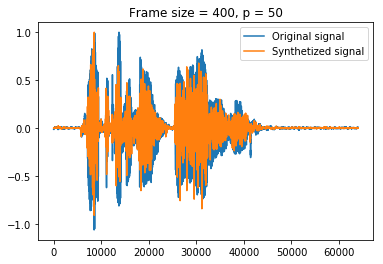

In [4]:
# Main parameters : order of the filter, size of the frames
p = 50 
frame_size = 400

# Overlap : the choice of analysis and synthesis windows is as in the STFT course
# Careful that it is only consistent for a 50% overlap
overlap_ratio = 0.5 
overlap = int(overlap_ratio*frame_size)
w_a = windows.cosine(frame_size)
w_s = windows.cosine(frame_size)

# Compute the number of frames and pad the input signal at the end with zeros
# to work only with full frames
nframes = int(np.ceil((len(s)-overlap)/(frame_size-overlap)))
padded_size = int((frame_size-overlap)*nframes+overlap)
s_padded = np.concatenate((s,np.zeros(padded_size-len(s))))
y = np.zeros(len(s_padded)) # Initialize the synthetised signal

for frame in range(0,nframes):
    start = frame*overlap
    end = start+frame_size
    y[start:end] = w_s*process_frame(w_a*s_padded[start:end],p)

y = y/np.max(y) # Renormalize


# Just as a visual check : plot both the original and synthezised signals
plt.plot(s,label='Original signal')
plt.plot(y,label='Synthetized signal')
plt.legend()
plt.title('Frame size = {}, p = {}'.format(frame_size,p))

#Read synthetised signal
IPython.display.Audio(y,rate=fs)

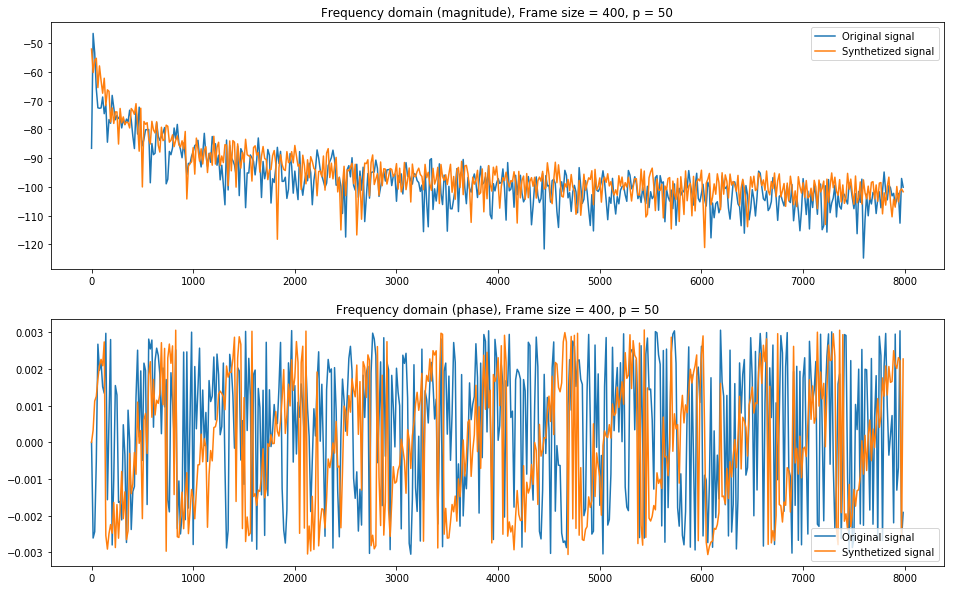

In [5]:
N = 1024
S = np.fft.fftshift(np.fft.fft(s, n=N))
Y = np.fft.fftshift(np.fft.fft(y, n=N))
freq = np.fft.fftshift(np.fft.fftfreq(N))*fs
ind = [ind for ind, values in enumerate(freq) if values >= 0]

fig, axes = plt.subplots(2, 1, figsize=(16, 10))
# Plot spectrum (Magnitude)
axes[0].plot(freq[ind], 20*np.log10(np.abs(S[ind])/N),label='Original signal')
axes[0].plot(freq[ind], 20*np.log10(np.abs(Y[ind])/N),label='Synthetized signal')
axes[0].legend()
axes[0].set_title('Frequency domain (magnitude), Frame size = {}, p = {}'.format(frame_size,p))

# Plot spectrum (Phase)
axes[1].plot(freq[ind], np.angle(S[ind])/N,label='Original signal')
axes[1].plot(freq[ind], np.angle(Y[ind])/N,label='Synthetized signal')
axes[1].legend()
axes[1].set_title('Frequency domain (phase), Frame size = {}, p = {}'.format(frame_size,p))

plt.show()

### Plot the NRJ of each frame

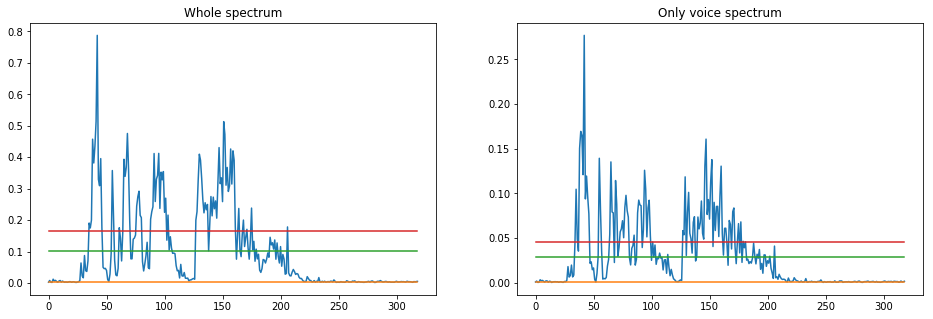

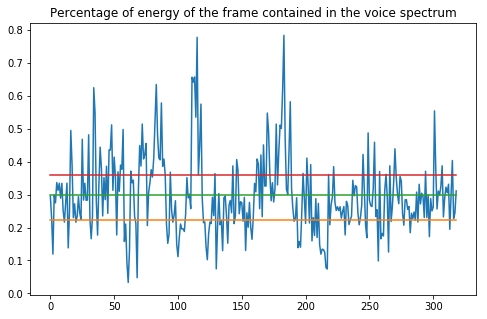

In [39]:
#from matplotlib import gridspec
E_min = 0.001
results1 = []
results2 = []
for frame in range(0,nframes):
    start = frame*overlap
    end = start+frame_size
    
    w = windows.cosine(frame_size)
    #plt.plot(test, label='original')
    #plt.plot(test*w, label='windowed')
    #plt.legend()
    
    N = 128
    Y = np.fft.fftshift(np.fft.fft(y[start:end], n=N))
    Y = Y[int(N/2):]
    #Y = Y[1:4]
    NRJ1 = np.sum(np.abs(Y)/N)
    NRJ2 = np.sum(np.abs(Y[1:4])/N)
    #if NRJ >= E_min :
    #    results.append(1)
    #else :
    #    results.append(0)
    results1.append(NRJ1)
    results2.append(NRJ2)


"""ind = np.array([ind for ind, values in enumerate(results) if values == 1])
speech_init = [ind[0]]
speech_end = []
for i, indice in enumerate(ind) :
    if i < len(ind) -1 :
        if indice + 1 != ind[i+1] :
            speech_end.append(indice)
            speech_init.append(ind[i+1])
    else :
        speech_end.append(indice)
print(np.array(speech_init)*frame_size/(2*fs))
print(np.array(speech_end)*frame_size/(2*fs))"""

fig, ax = plt.subplots(1, 2, figsize=[16, 5])

"""fig = plt.figure(figsize=[16, 12])
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(results1)

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(results2)

ax3 = fig.add_subplot(gs[1, 0:])
ax3.plot(np.array(results2)/np.array(results1))

gs.update(wspace=0.5, hspace=0.5)"""

# Plot the NRJ of each frame
ax[0].plot(results1)
ax[0].plot(np.percentile(results1, 25)*np.ones(len(results1))) # 1st quartile
ax[0].plot(np.mean(results1)*np.ones(len(results1)))           # median
ax[0].plot(np.percentile(results1, 75)*np.ones(len(results1))) # 3rd quartile
ax[0].set_title('Whole spectrum')

ax[1].plot(results2)
ax[1].plot(np.percentile(results2, 25)*np.ones(len(results2))) # 1st quartile
ax[1].plot(np.mean(results2)*np.ones(len(results2)))           # median
ax[1].plot(np.percentile(results2, 75)*np.ones(len(results2))) # 3rd quartile
ax[1].set_title('Only voice spectrum')

plt.show()

# Plot percentage of the NRJ contained in the voice spectrum
percentage = np.array(results2)/np.array(results1)
fig, ax = plt.subplots(1, 1, figsize=[8, 5])
ax.plot(percentage)
ax.plot(np.percentile(percentage, 25)*np.ones(len(percentage))) # 1st quartile
ax.plot(np.mean(percentage)*np.ones(len(percentage)))           # median
ax.plot(np.percentile(percentage, 75)*np.ones(len(percentage))) # 3rd quartile
ax.set_title('Percentage of energy of the frame contained in the voice spectrum')

plt.show()